Mini Data Competition
Imputation methods include single imputation (by mean), listwise deletion, KNN and MICE. 
Feature selection is carried out by univariate selection. 
The classification algorithm adopted is KNN. 
According to the instruction, I choose not to scale the data.
Grid search is conducted for hyperparametre tuning.
In the result, there are some values are 0 or 1, but they are truly the probability of Y=1.

In [53]:
# import data
q3df_test=pd.read_csv(r"C:\Users\I544708\Desktop\hands on\A1\Q3_test.csv")
q3df_train=pd.read_csv(r"C:\Users\I544708\Desktop\hands on\A1\Q3_train.csv")

In [54]:
# the purpose of running this block is to find the indices of missing data, to facilitate further filling nans
idx_q3, idy_q3 = np.where(pd.isnull(q3df_train))
nan_index_result_q3 = np.column_stack([q3df_train.index[idx_q3], q3df_train.columns[idy_q3]])
print(nan_index_result_q3)

[[0 'X1']
 [0 'X2']
 [0 'X3']
 ...
 [9999 'X3']
 [9999 'X5']
 [9999 'X8']]


In [57]:
# listwise deletion: delete rows where Y is null
q3df_train_dn1=q3df_train.dropna(subset=['Y'])

In [59]:
# define function to remove outliers by IQR method
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

In [60]:
# select continuous variables to do IQR outlier removal
q3df_train_dn1_cont=q3df_train_dn1[["X3","X4","X5","X6","X7","X8","X9","X10","X11","X12","X13","X14","X15","X16","X17","X18","X19"]]

In [72]:
q3df_train_remout=remove_outlier_IQR(q3df_train_dn1_cont) # IQR outliers removal

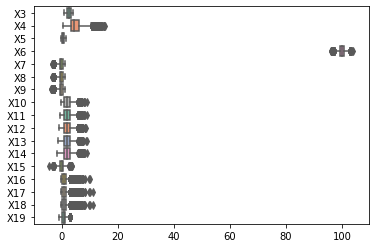

In [73]:
# check out the effectiveness of outlier removal
import seaborn as sns
import matplotlib.pyplot as plt

plt.clf()
ax = sns.boxplot(data=q3df_train_dn1_cont, orient="h", palette="Set2")
plt.show()

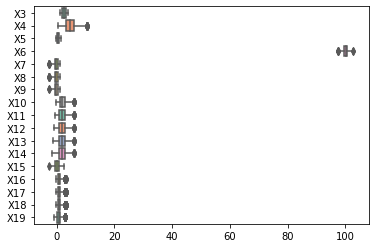

In [74]:
plt.clf()
ax = sns.boxplot(data=q3df_train_remout, orient="h", palette="Set2")
plt.show()

It is obvious to see that after IQR method, extremely values have been removed.

In [81]:
# imputate continuous variables by mean

from sklearn.impute import SimpleImputer
singimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
q3ary_train_contimp=singimp_mean.fit_transform(q3df_train_remout)

In [82]:
q3df_train_contimp=pd.DataFrame(q3ary_train_contimp) # convert from array to dataframe
q3df_train_contimp.columns=["X3","X4","X5","X6","X7","X8","X9","X10","X11","X12","X13","X14","X15","X16","X17","X18","X19"]

In [137]:
# deal with X0 categorical variable using KNN Imputation

from sklearn.impute import KNNImputer

q3df_train_dn1.reset_index(drop=True, inplace=True)
q3df_train_contimp.reset_index(drop=True, inplace=True)
q3df_train_knnimp=pd.concat([q3df_train_dn1["X0"],q3df_train_contimp],axis=1)

imputer_knn = KNNImputer(n_neighbors=5)
q3df_train_X0imp=pd.DataFrame(np.round_(imputer_knn.fit_transform(q3df_train_knnimp)[:,0]),columns=["X0"])

In [139]:
# deal with X1, X2 integer variable using MICE Imputation

q3df_train_dn1.reset_index(drop=True, inplace=True)
q3df_train_contimp.reset_index(drop=True, inplace=True)

q3df_train_miceimp=pd.concat([q3df_train_dn1[["X1","X2"]],q3df_train_contimp],axis=1)
kernel=MICEData(q3df_train_miceimp,k_pmm=3)
kernel.update_all(5)
q3df_train_X12imp=kernel.data[["X1",'X2']]

In [141]:
q3df_train_imped=pd.concat([q3df_train_X0imp,q3df_train_X12imp,q3df_train_contimp],axis=1) # final imputed dataset

In [147]:
dummies=pd.get_dummies(q3df_train_imped["X0"], drop_first=False) # encode X0 categorical variable
dummies.columns=["X0=0",'X0=1','X0=2']

In [157]:
q3df_train_imped.reset_index(drop=True, inplace=True)
dummies.reset_index(drop=True, inplace=True)

# separate X and Y
X_input=pd.concat([q3df_train_imped[["X1","X2","X3","X4","X5","X6","X7","X8","X9","X10","X11","X12","X13","X14","X15","X16","X17","X18","X19"]],dummies],axis=1)
y_input=q3df_train_dn1["Y"]

In [161]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier

# using univariate selection method to carry out feature selection, construct the FS function
def feature_selection_q3(i,X,y):
    kfs=SelectKBest(f_classif, k=i)
    X_selected = pd.DataFrame(kfs.fit_transform(X, y))
    X_selected_indica=kfs.get_support(indices=False)
    return  X_selected,X_selected_indica

In [166]:
from sklearn.neighbors import KNeighborsClassifier

X_selected_list=[]

for i in range(5,23): # number of features to be selected is adjustable
    X_selected,X_selected_indica=feature_selection_q3(i,X_input,y_input)    
    X_selected_list.append(X_selected_indica)
    
    neigh_q3 = KNeighborsClassifier()
    params = {
    'n_neighbors': [i for i in [3,5,7]],
    'weights': ['uniform','distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree']
    }
        
    folds = 5

    skf = KFold(n_splits=folds, shuffle = True, random_state = 1)

    grid_search_q3_knn = GridSearchCV(neigh_q3, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(X_selected,y_input), verbose=3)

    # carry out grid search to find best hyperparametre combination for each feature selectio context
    start_time = timer(None) # timing starts from this point for "start_time" variable
    print(grid_search_q3_knn.fit(X_selected,y_input))
    timer(start_time) # timing ends here for "start_time" variable

    print('Best estimator when '+str(i)+' features are selected: ')
    print(grid_search_q3_knn.best_estimator_)
    print('\n The AUC of the best estimator for 5-fold search, where each iteration with 18 hyperparameter combinations:')
    print(grid_search_q3_knn.best_score_)
    print('\n Best hyperparameters:')
    print(grid_search_q3_knn.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000012C56A17F68>,
             estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=3)

 Time taken: 0 hours 1 minutes and 7.86 seconds.
Best estimator when 5 features are selected: 
KNeighborsClassifier(n_neighbors=7, weights='distance')

 The AUC of the best estimator for 5-fold search, where each iteration with 18 hyperparameter combinations:
0.9517227341952925

 Best hyperparameters:
{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000012C56A11048>,
             estimator=KNeighborsClassifier(), n_jobs=4,
             param_

From the above results, it's easy to find that the best hyperparametre combination is {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'} under 6 features selected 

In [167]:
print(X_selected_list[1]) # check out which 6 features are selected

[False False  True False  True False False False False False False False
 False False False  True  True  True  True False False False]


In [169]:
X_selected_best=X_input[["X3",'X5','X16','X17','X18','X19']]
test_X_q3=q3df_test[["X3",'X5','X16','X17','X18','X19']]

# predict the probability of Y under with the best selected model
knn_clf=KNeighborsClassifier(n_neighbors=7, weights='distance')
knn_clf.fit(X_selected_best,y_input)
res_y_proba=knn_clf.predict_proba(test_X_q3) # predict probability


In [181]:
print(res_y_proba[:,1]) # extract the probability of Y=1 from the result 

[0.         1.         0.27097284 ... 1.         1.         0.        ]


In [182]:
final_result=pd.DataFrame(res_y_proba[:,1])
final_result.to_excel('final_result.xlsx') # to excel

C:\Users\I544708\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\compat\_optional.py:106: UserWarning: Pandas requires version '0.9.8' or newer of 'xlsxwriter' (version '0.9.6' currently installed).
  warnings.warn(msg, UserWarning)
